## Seaborn charting examples

### Load in wholesale data

In [1]:
import pandas as pd
import datetime as dt
import glob
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Read in NZ wholesale electricity prices from 2012 to 2021
prices = pd.read_csv('Wholesale_price_trends_20220820114423.csv', \
  header=8)
prices.head()

,Period start,Period end,Region ID,Region,Price ($/MWh)
0,01/01/2012,02/01/2012,OTA2201,OTA2201 - Otahuhu,48.13
1,01/01/2012,02/01/2012,WKM2201,WKM2201 - Whakamaru,44.29


In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Period start   14619 non-null  object 
 1   Period end     14619 non-null  object 
 2   Region ID      14619 non-null  object 
 3   Region         14619 non-null  object 
 4   Price ($/MWh)  14619 non-null  float64
dtypes: float64(1), object(4)
memory usage: 571.2+ KB


In [36]:
path = './generation_data'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f, header=8) for f in all_files)
generation = pd.concat(df_from_each_file, ignore_index=True)

generation.head(2)

,Period start,Period end,Region ID,Region,Generation (GWh),Generation ($)
0,01/01/2012,02/01/2012,OTA2202,OTA2202 - Otahuhu,0.000,0.00
1,01/01/2012,02/01/2012,HLY2201,HLY2201 - Huntly,6.955,352716.33


In [40]:
def data_clean(wholesale_df):
  #Convert columns to useful pandas datatypes
  wholesale_df['Period start'] = pd.to_datetime(wholesale_df['Period start'],dayfirst=True )
  wholesale_df['Period end'] = pd.to_datetime(wholesale_df['Period end'],dayfirst=True )
  wholesale_df = wholesale_df.astype({ \
    'Region ID': 'category', \
    'Region': 'category'})
  wholesale_df['day'] = wholesale_df['Period start'].dt.day  
  wholesale_df['week'] = wholesale_df['Period start'].dt.isocalendar().week
  wholesale_df['month'] = wholesale_df['Period start'].dt.month
  wholesale_df['year'] = wholesale_df['Period start'].dt.year  

  return wholesale_df

In [41]:
prices = data_clean(prices)
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Period start   14619 non-null  datetime64[ns]
 1   Period end     14619 non-null  datetime64[ns]
 2   Region ID      14619 non-null  category      
 3   Region         14619 non-null  category      
 4   Price ($/MWh)  14619 non-null  float64       
 5   week           14619 non-null  UInt32        
 6   month          14619 non-null  int64         
 7   year           14619 non-null  int64         
 8   day            14619 non-null  int64         
dtypes: UInt32(1), category(2), datetime64[ns](2), float64(1), int64(3)
memory usage: 786.1 KB


In [42]:
generation = data_clean(generation)
generation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753340 entries, 0 to 753339
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Period start      753340 non-null  datetime64[ns]
 1   Period end        753340 non-null  datetime64[ns]
 2   Region ID         753340 non-null  category      
 3   Region            753340 non-null  category      
 4   Generation (GWh)  753340 non-null  float64       
 5   Generation ($)    753340 non-null  float64       
 6   day               753340 non-null  int64         
 7   week              753340 non-null  UInt32        
 8   month             753340 non-null  int64         
 9   year              753340 non-null  int64         
dtypes: UInt32(1), category(2), datetime64[ns](2), float64(2), int64(3)
memory usage: 46.7 MB


## Chart wholesale data

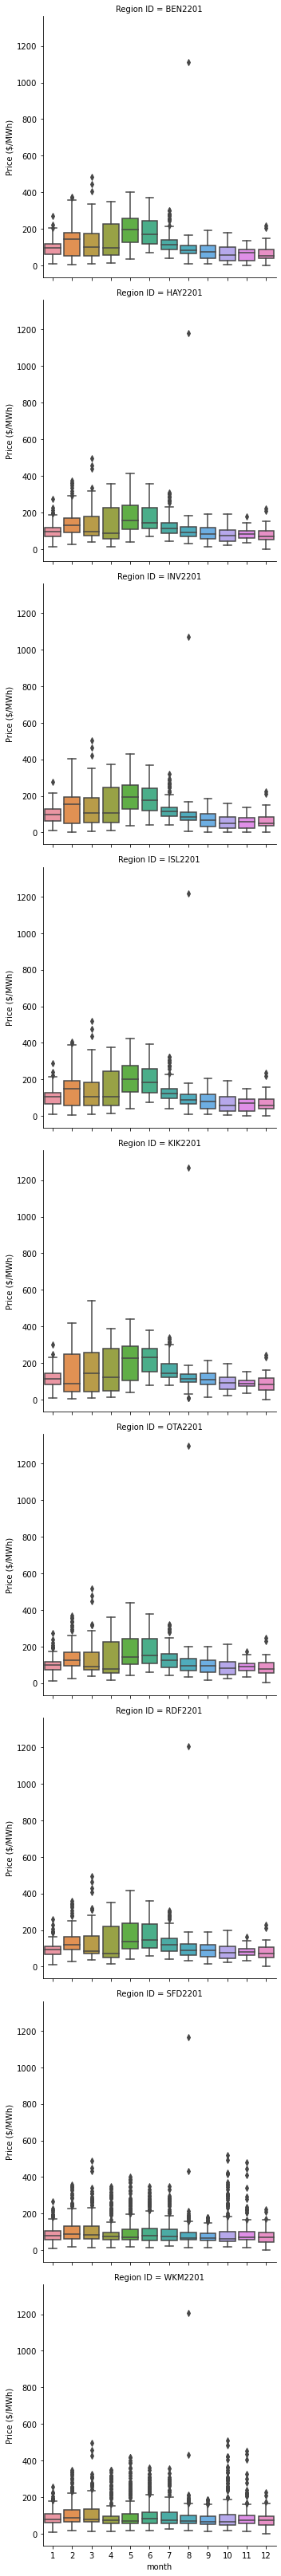

In [50]:
sns.catplot(x = 'month', y = 'Price ($/MWh)', \
  kind = 'box', data = prices, \
  row ='Region ID')

plt.show()